In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
import shapely.geometry as shp

Premier etape faire un circuit

Ref : *Spline_continuity.py* from PythonRobotics

La longueure de la track est de 32.61 mètre


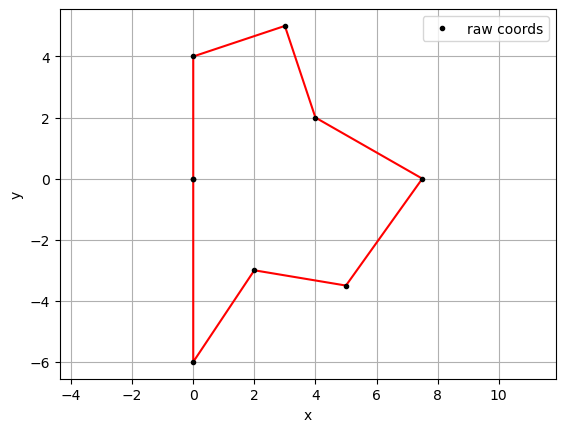

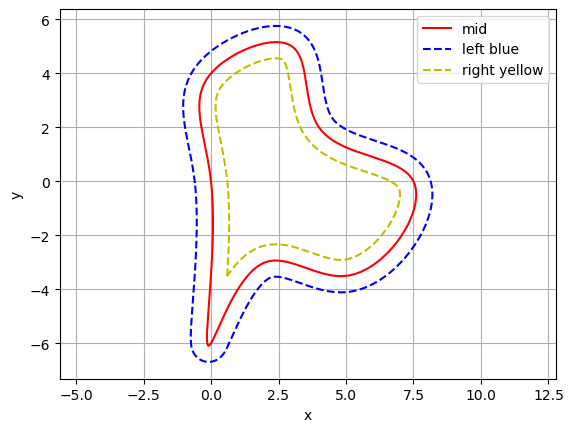

In [58]:
class Track:
    

    def __init__(self, x, y):
        self.x = np.r_[x, x[0]] #close the track
        self.y = np.r_[y, y[0]]
        self.thickness = 1.5 # thinckness of the track
    
    """
    J'ai choisi de prendre cette interpolation mais on pourrais en prendre une autre si celle la ne nous plait pas
    """
    def interpolation(self, x, y):
        tck,u = interpolate.splprep([x, y], s=0, per=True)
        x_smooth, y_smooth = interpolate.splev(np.linspace(0, 1, 1000), tck)
        self.x_smooth, self.y_smooth = x_smooth, y_smooth
        return(x_smooth, y_smooth)
        
    def poly_track(self): #transforme l'array en shape pour pouvoir faire des manipulation geometrique
        self.interpolation(self.x, self.y)
        return(shp.Polygon(zip(self.x_smooth, self.y_smooth)))
    
    def array_mid(self): # renvoie un array de la ligne mid apres interpolation
        return(np.array(self.poly_track().exterior))
    
    def array_left_corner(self): # renvoie un array de la ligne mid apres interpolation
        return(np.array(self.poly_track().buffer(self.thickness/2).exterior))
    
    def array_right_corner(self): # renvoie un array de la ligne mid apres interpolation
        return(np.array(self.poly_track().buffer(-self.thickness/2).exterior))
    
    def show_poly(self): # permet de show le track sans l'interpolation
        poly_tack_nonsmooth = shp.Polygon(zip(self.x, self.y))
        poly_track_array = np.array(poly_tack_nonsmooth.exterior)
        
        plt.plot(*poly_track_array.T,'r-')
        plt.plot(*poly_track_array.T,'k.',label="raw coords")
        
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
            
    def show_mid(self):
        poly_track_array = np.array(self.poly_track().exterior)
        
        plt.plot(*poly_track_array.T,'-r',label="mid")
        
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    def show_exter(self):
        poly_left_corner = self.poly_track().buffer(self.thickness/2)  # Outward offset
        poly_right_corner = self.poly_track().buffer(-self.thickness/2)  # Inward offset
        
        poly_left_corner_array = np.array(poly_left_corner.exterior)
        poly_right_corner_array = np.array(poly_right_corner.exterior)
        
        plt.plot(*poly_left_corner_array.T, '--b', label="left blue")
        plt.plot(*poly_right_corner_array.T, '--y', label="right yellow")
        
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    def show_track(self):
        poly_left_corner = self.poly_track().buffer(0.6)  # Outward offset
        poly_right_corner = self.poly_track().buffer(-0.6)  # Inward offset
        
        poly_track_array = np.array(self.poly_track().exterior)
        poly_left_corner_array = np.array(poly_left_corner.exterior)
        poly_right_corner_array = np.array(poly_right_corner.exterior)
        
        plt.plot(*poly_track_array.T,'-r', label="mid")
        plt.plot(*poly_left_corner_array.T, '--b', label="left blue")
        plt.plot(*poly_right_corner_array.T, '--y', label="right yellow")
        
        plt.grid(True)
        plt.axis("equal")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.show()
        
    def details(self):
        self.lenght = self.poly_track().length
        
        
x = [0, 0, 2, 5.0, 7.5, 4.0, 3.0, 0]
y = [0, -6, -3, -3.5, 0.0, 2.0, 5.0, 4]

T1 = Track(x,y)
T1.details()
print("La longueure de la track est de {lenght:.2f} mètre".format(lenght = T1.lenght))
T1.show_poly()
# display(T1.array_mid())
# display(T1.array_left_corner())
# display(T1.array_right_corner())
T1.show_track()
# T1.show_exter()
# T1.show_mid()

        

Deplacer un cursor sur le circuit

Deplacer un cursor sur le circuit **Avec un cursor**

Creer L'objet voiture

Creer un modele **simple** de la voiture

Faire reagir la voiture a un modele

creer class pour transformer les data en coords

Documentation

Faire le powerpoint : 
- expliquer le path plannig
- path tracking
- les algo pour le path planning / tracking
- ce que j'ai actuellement
- ce que je suis en train de faire
- ce que je compte faire moyen 
- long terme
- references
- 

Quentin Ros : 
- Input
  - cord Voiture
  - Cord cone bleu / jane / unknow color /unsorted 
  - Autre ? 

- Output :
  - steering
  - throthle
  - breack ?
  - EBS si pb detecter dans le le *planning*
  - Atre ? (Slam ?) 

In [ ]:
class Car:
    def __init__(self,x=0,y=0):
        self.x = x
        self.y = y
        
    def model(self):
        self.y = self.x
        